## Mathematical Description of the Model

This notebook implements a numerical method for solving **optimal control problems** involving the evolution of probability distributions governed by a controlled nonlocal continuity equation. Specifically, we study dynamics on the periodic two-dimensional domain (torus) \(\mathbb{T}^2 \equiv [0,2\pi]^2\).

The evolution of a probability density \(\rho_t(x)\) on \(\mathbb{T}^2\) is described by a controlled continuity equation of the form:

$$
\partial_t \rho_t(x) + \nabla \cdot \left(f_t[\rho_t,u_t](x)\,\rho_t(x)\right)=0,\quad \rho_0(x)=\rho_0.
$$

Here:

- \(\rho_t(x)\) is the probability density at time \(t\).
- \(u_t\) is the control input influencing the vector field.
- The drift vector field \(f_t(x,\rho,u)\) is given by a nonlocal (attention-like) mechanism:
\[
f_t(x,\rho,u) = V_t \frac{\int_{\mathbb{T}^2} k_\kappa(x,y)\,y\,\rho_t(y)\,dy}{\int_{\mathbb{T}^2} k_t(x,y)\,\rho(y)\,dy} + b_t,
\]
with the kernel
\[
k_t(x,y) = \exp\left(\kappa\, \sum_{j=1}^2 \cos(x_j - y_j)\right),
\]
which models periodic (torus-like) self-attention interactions between points. Here, the matrix \(V_t\) and bias \(b_t\) serve as learnable control parameters, and \(\kappa\) controls the concentration strength of interactions.

### Control Objective

We aim to steer the probability density \(\rho_t\) toward a desired target distribution \(\hat{\rho}(x)\) at final time \(T\). To do this, we minimize a quadratic cost functional of the form:
\[
J(u) = \int_{\mathbb{T}^2} |\rho_T(x; u) - \hat{\rho}(x)|^2\, dx.
\]

### Numerical Method

The numerical implementation relies on:

- **Spectral Methods:**  
  Fast Fourier transforms (FFT) are used to efficiently compute spatial derivatives, enhancing accuracy and computational performance.

- **Fourth-order Runge–Kutta (RK4):**  
  Used for time integration to achieve stable and accurate evolution of the PDE solution.

- **Optimization via Sign-based Gradient Approximation:**  
The algorithm computes approximate directional derivatives of the cost functional and uses a simple sign-based update rule to iteratively improve controls, leading to convergence in few iterations.

### Code Implementation Notes:

- The implementation leverages GPU acceleration with CuPy when available, otherwise defaults to NumPy for CPU computations.
- Density plots and cost histories are generated to visualize convergence behavior.


GPU not available or an error occurred in CuPy; falling back to NumPy. Error: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version
Iteration 0, Cost: 2.5428e-01


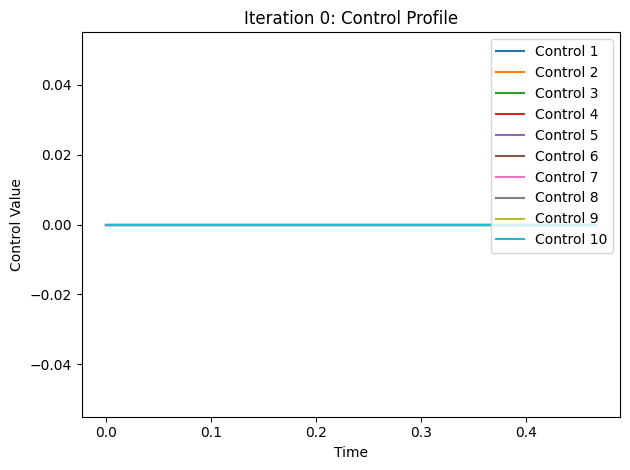

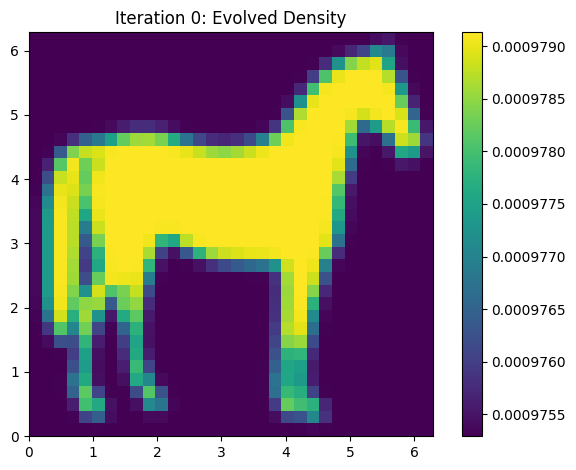

In [ ]:
# Try to use the pre-installed CuPy on GPU; otherwise fall back to NumPy on CPU.
try:
    import cupy as cp
    # Test a small operation to ensure GPU is accessible.
    cp.array([1, 2, 3])
    xp = cp
    use_gpu = True
    print("Using pre-installed CuPy on GPU.")
except Exception as e:
    print("GPU not available or an error occurred in CuPy; falling back to NumPy. Error:", e)
    import numpy as np
    xp = np
    use_gpu = False

import numpy as np  # For plotting conversion if using GPU.
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize

def to_numpy(arr):
    """Convert array to NumPy array if it's on GPU (CuPy)."""
    if use_gpu:
        return cp.asnumpy(arr)
    else:
        return arr

def get_user_config():
    config = {}

    # PDE / domain parameters
    config["res"] = 32            # Grid resolution
    config["T"]   = 0.5           # Total time horizon
    config["h"]   = config["T"] / 15
    config["epsilon"] = 0.1
    config["N_iter"] = 1

    # Query/Key matrices (fixed) for attention (here, Q=K=I)
    config["Q_mat"] = xp.array([[1.0, 0.0],
                                [0.0, 1.0]])
    config["K_mat"] = xp.array([[1.0, 0.0],
                                [0.0, 1.0]])

    # Control dimension: 10 channels (first 4 for local drift are unused)
    config["num_channels"] = 10

    # Initial control array
    n_intervals = int(config["T"] / config["h"])
    config["initial_control"] = xp.zeros((config["num_channels"], n_intervals))

    # Active channels (not strictly used here)
    config["active"] = xp.array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0], dtype=xp.float32)

    # Spectral sub-steps and aliasing filter
    config["num_steps_per_interval"] = 16
    config["use_two_thirds_filter"]  = True

    # Sign-based update factor (unused in vectorized code)
    config["sign_factor"] = 300.0

    # Density clipping
    config["rho_clip"] = 1e-15

    # (Unused) local drift parameters removed.
    config["use_sigmoid_local"] = True

    # Smoothness penalty weight
    config["lam_cost"] = 0.00000

    # Reference point for cost (torus wrapping)
    config["xstar"] = 0.
    config["ystar"] = 0.

    # Concentration parameter for periodic attention kernel
    config["kappa"] = 5.0

    return config

def main_simulation(config):
    # Unpack configuration parameters
    res   = config["res"]
    T     = config["T"]
    h     = config["h"]
    eps   = config["epsilon"]
    N_iter= config["N_iter"]
    Q_mat = config["Q_mat"]
    K_mat = config["K_mat"]
    kappa = config["kappa"]

    num_channels = config["num_channels"]
    bar_u        = config["initial_control"].copy()
    num_steps_per_interval = config["num_steps_per_interval"]
    use_two_thirds_filter  = config["use_two_thirds_filter"]
    rho_clip               = config["rho_clip"]

    xstar = config["xstar"]
    ystar = config["ystar"]

    # ---------- Grid Setup ----------
    x = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    y = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    dx = 2*xp.pi / res
    X, Y = xp.meshgrid(x, y, indexing='ij')
    area_el = float(dx * dx)

    # Frequencies for spectral derivatives (using xp.fft)
    k = xp.fft.fftfreq(res) * res
    kx, ky = xp.meshgrid(k, k, indexing='ij')

    # ========== Initial Density ==========
    # Use NumPy for image processing and then convert to xp.array.
    image = data.horse().astype(float)
    image_inverted = 255 - image
    image_resized = resize(image_inverted, (res, res), anti_aliasing=True)
    image_resized = np.flipud(image_resized)
    rho_initial = xp.array(image_resized) / xp.sum(image_resized)
    original_rho = rho_initial.copy()

    # Flattened coordinate array for attention computations
    coords = xp.stack([X.flatten(), Y.flatten()], axis=1)
    N = coords.shape[0]  # total grid points

    # ========== 2/3 Aliasing Filter ==========
    def two_thirds_filter(f_hat):
        Nx, Ny = f_hat.shape
        cutoff_x = Nx // 3
        cutoff_y = Ny // 3
        f_hat[cutoff_x:-cutoff_x, :] = 0
        f_hat[:, cutoff_y:-cutoff_y] = 0
        return f_hat

    # ========== Local Drift (Removed) ==========
    def compute_local_drift(u):
        # Local drift is removed; return zeros.
        return xp.zeros_like(X), xp.zeros_like(X)

    # ========== Periodic Attention Drift ==========
    def compute_periodic_attention_drift(rho, u):
        """
        f_attn(p) = V * [ ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) y rho(y) dy /
                           ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) rho(y) dy ] + b
        (with Q=K=I, so (Qx)_j = x_j and (Ky)_j = y_j)
        """
        # Extract V (channels 4:8) and b (channels 8:10)
        V = xp.array([[u[4], u[5]],
                      [u[6], u[7]]])
        b = xp.array([u[8], u[9]])

        rho_flat = rho.flatten()  # shape (N,)

        # p_proj and q_proj are simply coords here.
        p_proj = coords  # shape (N,2)
        q_proj = coords  # shape (N,2)

        # Inline vectorized periodic difference:
        diff_mat = p_proj[:, None, :] - q_proj[None, :, :]  # shape (N,N,2)
        # Wrap differences to [-pi, pi]
        diff_mat = (diff_mat + xp.pi) % (2*xp.pi) - xp.pi

        # Compute cosine similarity for each coordinate and sum over dimensions:
        cos_sum = xp.cos(diff_mat[..., 0]) + xp.cos(diff_mat[..., 1])  # shape (N,N)
        stable_scores = kappa * cos_sum
        row_max = xp.max(stable_scores, axis=1, keepdims=True)
        stable_scores = stable_scores - row_max  # for numerical stability
        exp_scores = xp.exp(stable_scores)

        weights = exp_scores * rho_flat[None, :]  # shape (N,N)
        denom = xp.sum(weights, axis=1) + 1e-15
        num = weights @ coords  # shape (N,2)
        attn_vec = num / denom[:, None]
        attn_out = attn_vec @ V.T + b

        return attn_out.reshape((res, res, 2))[:,:,0], attn_out.reshape((res, res, 2))[:,:,1]

    # ========== PDE Derivative ==========
    def compute_rho_derivative(t, rho, u):
        # Local drift is zero
        _, _ = compute_local_drift(u)
        non_x, non_y = compute_periodic_attention_drift(rho, u)
        drift_x = non_x
        drift_y = non_y

        flux_x = rho * drift_x
        flux_y = rho * drift_y

        flux_x_hat = xp.fft.fft2(flux_x)
        flux_y_hat = xp.fft.fft2(flux_y)

        if use_two_thirds_filter:
            flux_x_hat = two_thirds_filter(flux_x_hat)
            flux_y_hat = two_thirds_filter(flux_y_hat)

        div_flux = xp.fft.ifft2(1j * kx * flux_x_hat + 1j * ky * flux_y_hat).real
        return -div_flux

    # ========== Helper: Torus-Wrapped Coordinate Difference ==========
    def torus_diff(A, a_star):
        return (A - a_star + xp.pi) % (2*xp.pi) - xp.pi

    # ========== Cost Functional (α=2) ==========
    def compute_cost(rho):
        dx_wrap = torus_diff(X, xstar)
        dy_wrap = torus_diff(Y, ystar)
        return float(xp.sum((dx_wrap**2 + dy_wrap**2) * rho) * area_el)

    # ========== Time-Stepping ==========
    def simulate_duration(t0, rho_init, control_intervals, total_time, interval_length):
        rho = rho_init.copy()
        t = t0
        dt = interval_length / num_steps_per_interval
        n_full = int(total_time // interval_length)
        remainder = total_time - n_full * interval_length

        for j in range(n_full):
            if j < control_intervals.shape[1]:
                u = control_intervals[:, j]
            else:
                u = control_intervals[:, -1]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k2, u)
                k4 = compute_rho_derivative(t + dt, rho + dt*k3, u)
                rho += dt * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        if remainder > 1e-10:
            dt_partial = remainder / num_steps_per_interval
            idx_use = min(n_full, control_intervals.shape[1]-1)
            u = control_intervals[:, idx_use]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k2, u)
                k4 = compute_rho_derivative(t + dt_partial, rho + dt_partial*k3, u)
                rho += dt_partial * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt_partial
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        return rho, t

    def simulate(t0, rho_init, control_intervals, interval_length):
        total_time = control_intervals.shape[1] * interval_length
        rho_out, _ = simulate_duration(t0, rho_init, control_intervals, total_time, interval_length)
        return rho_out

    # ========== Iterative Control Update (Sign-based) ==========
    n_intervals = int(T / h)
    if bar_u.shape != (num_channels, n_intervals):
        raise ValueError(f"Expected bar_u shape ({num_channels}, {n_intervals}), got {bar_u.shape}")

    cost_history = []
    density_evolution = []
    control_history = []
    rho_current_main = rho_initial.copy()

    for k_iter in range(N_iter):
        # Evolve PDE using current controls
        rho_T = simulate(0, rho_current_main, bar_u, h)
        current_cost = compute_cost(rho_T)
        print(f"Iteration {k_iter}, Cost: {current_cost:.4e}")
        cost_history.append(current_cost)
        density_evolution.append(rho_T)

        # Plot and Save Control Profiles
        t_vals = np.arange(n_intervals) * h
        plt.figure()
        for ch in range(num_channels):
            plt.plot(np.array(t_vals), np.array(to_numpy(bar_u[ch, :])), label=f'Control {ch+1}')
        plt.xlabel('Time')
        plt.ylabel('Control Value')
        plt.title(f'Iteration {k_iter}: Control Profile')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"control_profile_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Plot and Save Evolved Density
        plt.figure()
        plt.imshow(to_numpy(rho_T), extent=[0, 2*xp.pi, 0, 2*xp.pi], origin='lower', cmap='viridis')
        plt.title(f'Iteration {k_iter}: Evolved Density')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(f"evolved_density_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Sign-based Update
        t_current = 0.0
        idx = 0
        rho_iter = rho_current_main.copy()
        u_new = xp.zeros_like(bar_u)
        while t_current < T and idx < n_intervals:
            remaining_time = T - t_current
            if bar_u.shape[1] > idx:
                current_controls = bar_u[:, idx:]
            else:
                current_controls = bar_u[:, -1].reshape(num_channels, 1)
            y_bar = simulate_duration(t_current, rho_iter, current_controls, remaining_time, h)[0]
            base_cost = compute_cost(y_bar)
            u_t = xp.zeros(num_channels)
            for i in range(num_channels):
                perturb = xp.zeros((num_channels, 1))
                perturb[i, 0] = 1.0
                y_pert = simulate_duration(t_current, rho_iter, perturb, eps, eps)[0]
                z_bar = simulate_duration(t_current, y_pert, current_controls, remaining_time, h)[0]
                cost_pert = compute_cost(z_bar)
                u_t[i] = np.sign(base_cost - cost_pert)
            u_new[:, idx] = u_t
            rho_iter = simulate_duration(t_current, rho_iter, u_t.reshape(num_channels, 1), h, h)[0]
            t_current += h
            idx += 1

        bar_u = u_new.copy()
        control_history.append(bar_u.copy())
        # Re-simulate from 0 to T with new controls
        rho_current_main = simulate(0, rho_current_main, bar_u, h)

    # Final Results
    rho_final = simulate(0, rho_current_main, bar_u, h)
    final_cost = compute_cost(rho_final)
    print(f"Final Cost: {final_cost:.4e}")

    # Final Summary Plots: Display and Save
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(to_numpy(original_rho), extent=[0, 2*xp.pi, 0, 2*xp.pi], origin='lower', cmap='viridis')
    plt.title('Initial Density')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(to_numpy(rho_final), extent=[0, 2*xp.pi, 0, 2*xp.pi], origin='lower', cmap='viridis')
    plt.title('Final Evolved Density')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.plot(range(N_iter), cost_history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost History')
    plt.tight_layout()
    plt.savefig("final_results.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

if __name__ == "__main__":
    config = get_user_config()
    main_simulation(config)

In [ ]:
# Try to use the pre-installed CuPy on GPU; otherwise fall back to NumPy on CPU.
try:
    import cupy as cp
    # Test a small operation to ensure GPU is accessible.
    cp.array([1, 2, 3])
    xp = cp
    use_gpu = True
    print("Using pre-installed CuPy on GPU.")
except Exception as e:
    print("GPU not available or an error occurred in CuPy; falling back to NumPy. Error:", e)
    import numpy as np
    xp = np
    use_gpu = False

import numpy as np  # For plotting conversion if using GPU.
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize

def to_numpy(arr):
    """Convert array to NumPy array if it's on GPU (CuPy)."""
    if use_gpu:
        return cp.asnumpy(arr)
    else:
        return arr

def get_user_config():
    config = {}

    # PDE / domain parameters
    config["res"] = 64            # Grid resolution
    config["T"]   = 0.5           # Total time horizon
    config["h"]   = config["T"] / 5
    config["epsilon"] = 0.1 * config["h"]
    config["N_iter"] = 1

    # Query/Key matrices (fixed) for attention (here, Q=K=I)
    config["Q_mat"] = xp.array([[1.0, 0.0],
                                [0.0, 1.0]])
    config["K_mat"] = xp.array([[1.0, 0.0],
                                [0.0, 1.0]])

    # Control dimension: 10 channels (first 4 for local drift are unused)
    config["num_channels"] = 10

    # Initial control array
    n_intervals = int(config["T"] / config["h"])
    config["initial_control"] = xp.zeros((config["num_channels"], n_intervals))

    # Active channels (not strictly used here)
    config["active"] = xp.array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0], dtype=xp.float32)

    # Spectral sub-steps and aliasing filter
    config["num_steps_per_interval"] = 16
    config["use_two_thirds_filter"]  = True

    # Sign-based update factor (unused in vectorized code)
    config["sign_factor"] = 300.0

    # Density clipping
    config["rho_clip"] = 1e-15

    # (Unused) local drift parameters removed.
    config["use_sigmoid_local"] = True

    # Smoothness penalty weight
    config["lam_cost"] = 0.00000

    # Reference point for cost (torus wrapping)
    config["xstar"] = 0.
    config["ystar"] = 0.

    # Concentration parameter for periodic attention kernel
    config["kappa"] = 5.0

    return config

def main_simulation(config):
    # Unpack configuration parameters
    res   = config["res"]
    T     = config["T"]
    h     = config["h"]
    eps   = config["epsilon"]
    N_iter= config["N_iter"]
    Q_mat = config["Q_mat"]
    K_mat = config["K_mat"]
    kappa = config["kappa"]

    num_channels = config["num_channels"]
    bar_u        = config["initial_control"].copy()
    num_steps_per_interval = config["num_steps_per_interval"]
    use_two_thirds_filter  = config["use_two_thirds_filter"]
    rho_clip               = config["rho_clip"]

    xstar = config["xstar"]
    ystar = config["ystar"]

    # ---------- Grid Setup ----------
    x = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    y = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    dx = 2*xp.pi / res
    X, Y = xp.meshgrid(x, y, indexing='ij')
    area_el = float(dx * dx)

    # Frequencies for spectral derivatives (using xp.fft)
    k = xp.fft.fftfreq(res) * res
    kx, ky = xp.meshgrid(k, k, indexing='ij')

    # ========== Initial Density ==========
    # Use NumPy for image processing and then convert to xp.array.
    image = data.checkerboard().astype(float)
    image_inverted = 255 - image
    image_resized = resize(image_inverted, (res, res), anti_aliasing=True)
    image_resized = np.flipud(image_resized)
    rho_initial = xp.array(image_resized) / xp.sum(image_resized)
    original_rho = rho_initial.copy()

    # Flattened coordinate array for attention computations
    coords = xp.stack([X.flatten(), Y.flatten()], axis=1)
    N = coords.shape[0]  # total grid points

    # ========== 2/3 Aliasing Filter ==========
    def two_thirds_filter(f_hat):
        Nx, Ny = f_hat.shape
        cutoff_x = Nx // 3
        cutoff_y = Ny // 3
        f_hat[cutoff_x:-cutoff_x, :] = 0
        f_hat[:, cutoff_y:-cutoff_y] = 0
        return f_hat

    # ========== Local Drift (Removed) ==========
    def compute_local_drift(u):
        # Local drift is removed; return zeros.
        return xp.zeros_like(X), xp.zeros_like(X)

    # ========== Periodic Attention Drift ==========
    def compute_periodic_attention_drift(rho, u):
        """
        f_attn(p) = V * [ ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) y rho(y) dy /
                           ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) rho(y) dy ] + b
        (with Q=K=I, so (Qx)_j = x_j and (Ky)_j = y_j)
        """
        # Extract V (channels 4:8) and b (channels 8:10)
        V = xp.array([[u[4], u[5]],
                      [u[6], u[7]]])
        b = xp.array([u[8], u[9]])

        rho_flat = rho.flatten()  # shape (N,)

        # p_proj and q_proj are simply coords here.
        p_proj = coords  # shape (N,2)
        q_proj = coords  # shape (N,2)

        # Inline vectorized periodic difference:
        diff_mat = p_proj[:, None, :] - q_proj[None, :, :]  # shape (N,N,2)
        # Wrap differences to [-pi, pi]
        diff_mat = (diff_mat + xp.pi) % (2*xp.pi) - xp.pi

        # Compute cosine similarity for each coordinate and sum over dimensions:
        cos_sum = xp.cos(diff_mat[..., 0]) + xp.cos(diff_mat[..., 1])  # shape (N,N)
        stable_scores = kappa * cos_sum
        row_max = xp.max(stable_scores, axis=1, keepdims=True)
        stable_scores = stable_scores - row_max  # for numerical stability
        exp_scores = xp.exp(stable_scores)

        weights = exp_scores * rho_flat[None, :]  # shape (N,N)
        denom = xp.sum(weights, axis=1) + 1e-15
        num = weights @ coords  # shape (N,2)
        attn_vec = num / denom[:, None]
        attn_out = attn_vec @ V.T + b

        return attn_out.reshape((res, res, 2))[:,:,0], attn_out.reshape((res, res, 2))[:,:,1]

    # ========== PDE Derivative ==========
    def compute_rho_derivative(t, rho, u):
        # Local drift is zero
        _, _ = compute_local_drift(u)
        non_x, non_y = compute_periodic_attention_drift(rho, u)
        drift_x = non_x
        drift_y = non_y

        flux_x = rho * drift_x
        flux_y = rho * drift_y

        flux_x_hat = xp.fft.fft2(flux_x)
        flux_y_hat = xp.fft.fft2(flux_y)

        if use_two_thirds_filter:
            flux_x_hat = two_thirds_filter(flux_x_hat)
            flux_y_hat = two_thirds_filter(flux_y_hat)

        div_flux = xp.fft.ifft2(1j * kx * flux_x_hat + 1j * ky * flux_y_hat).real
        return -div_flux

    # ========== Helper: Torus-Wrapped Coordinate Difference ==========
    def torus_diff(A, a_star):
        return (A - a_star + xp.pi) % (2*xp.pi) - xp.pi

    # ========== Cost Functional (α=2) ==========
    def compute_cost(rho):
        dx_wrap = torus_diff(X, xstar)
        dy_wrap = torus_diff(Y, ystar)
        return float(xp.sum((dx_wrap**2 + dy_wrap**2) * rho) * area_el)

    # ========== Time-Stepping ==========
    def simulate_duration(t0, rho_init, control_intervals, total_time, interval_length):
        rho = rho_init.copy()
        t = t0
        dt = interval_length / num_steps_per_interval
        n_full = int(total_time // interval_length)
        remainder = total_time - n_full * interval_length

        for j in range(n_full):
            if j < control_intervals.shape[1]:
                u = control_intervals[:, j]
            else:
                u = control_intervals[:, -1]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k2, u)
                k4 = compute_rho_derivative(t + dt, rho + dt*k3, u)
                rho += dt * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        if remainder > 1e-10:
            dt_partial = remainder / num_steps_per_interval
            idx_use = min(n_full, control_intervals.shape[1]-1)
            u = control_intervals[:, idx_use]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k2, u)
                k4 = compute_rho_derivative(t + dt_partial, rho + dt_partial*k3, u)
                rho += dt_partial * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt_partial
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        return rho, t

    def simulate(t0, rho_init, control_intervals, interval_length):
        total_time = control_intervals.shape[1] * interval_length
        rho_out, _ = simulate_duration(t0, rho_init, control_intervals, total_time, interval_length)
        return rho_out

    # ========== Iterative Control Update (Sign-based) ==========
    n_intervals = int(T / h)
    if bar_u.shape != (num_channels, n_intervals):
        raise ValueError(f"Expected bar_u shape ({num_channels}, {n_intervals}), got {bar_u.shape}")

    cost_history = []
    density_evolution = []
    control_history = []
    rho_current_main = rho_initial.copy()

    for k_iter in range(N_iter):
        # Evolve PDE using current controls
        rho_T = simulate(0, rho_current_main, bar_u, h)
        current_cost = compute_cost(rho_T)
        print(f"Iteration {k_iter}, Cost: {current_cost:.4e}")
        cost_history.append(current_cost)
        density_evolution.append(rho_T)

        # Plot and Save Control Profiles
        t_vals = np.arange(n_intervals) * h
        plt.figure()
        for ch in range(num_channels):
            plt.plot(np.array(t_vals), np.array(to_numpy(bar_u[ch, :])), label=f'Control {ch+1}')
        plt.xlabel('Time')
        plt.ylabel('Control Value')
        plt.title(f'Iteration {k_iter}: Control Profile')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"control_profile_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Plot and Save Evolved Density
        plt.figure()
        plt.imshow(to_numpy(rho_T), extent=[0, 2*xp.pi, 0, 2*xp.pi], origin='lower', cmap='viridis')
        plt.title(f'Iteration {k_iter}: Evolved Density')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(f"evolved_density_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Sign-based Update
        t_current = 0.0
        idx = 0
        rho_iter = rho_current_main.copy()
        u_new = xp.zeros_like(bar_u)
        while t_current < T and idx < n_intervals:
            remaining_time = T - t_current
            if bar_u.shape[1] > idx:
                current_controls = bar_u[:, idx:]
            else:
                current_controls = bar_u[:, -1].reshape(num_channels, 1)
            y_bar = simulate_duration(t_current, rho_iter, current_controls, remaining_time, h)[0]
            base_cost = compute_cost(y_bar)
            u_t = xp.zeros(num_channels)
            for i in range(num_channels):
                perturb = xp.zeros((num_channels, 1))
                perturb[i, 0] = 1.0
                y_pert = simulate_duration(t_current, rho_iter, perturb, eps, eps)[0]
                z_bar = simulate_duration(t_current, y_pert, current_controls, remaining_time, h)[0]
                cost_pert = compute_cost(z_bar)
                u_t[i] = np.sign(base_cost - cost_pert)
            u_new[:, idx] = u_t
            rho_iter = simulate_duration(t_current, rho_iter, u_t.reshape(num_channels, 1), h, h)[0]
            t_current += h
            idx += 1

        bar_u = u_new.copy()
        control_history.append(bar_u.copy())
        # Re-simulate from 0 to T with new controls
        rho_current_main = simulate(0, rho_current_main, bar_u, h)

    # Final Results
    rho_final = simulate(0, rho_current_main, bar_u, h)
    final_cost = compute_cost(rho_final)
    print(f"Final Cost: {final_cost:.4e}")

    # Final Summary Plots: Display and Save
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(to_numpy(original_rho), extent=[0, 2*xp.pi, 0, 2*xp.pi], origin='lower', cmap='viridis')
    plt.title('Initial Density')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(to_numpy(rho_final), extent=[0, 2*xp.pi, 0, 2*xp.pi], origin='lower', cmap='viridis')
    plt.title('Final Evolved Density')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.plot(range(N_iter), cost_history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost History')
    plt.tight_layout()
    plt.savefig("final_results.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

if __name__ == "__main__":
    config = get_user_config()
    main_simulation(config)

Using pre-installed CuPy on GPU.


KeyboardInterrupt: 

Using CuPy on GPU.
Iteration 0, Cost: 2.5404e-01


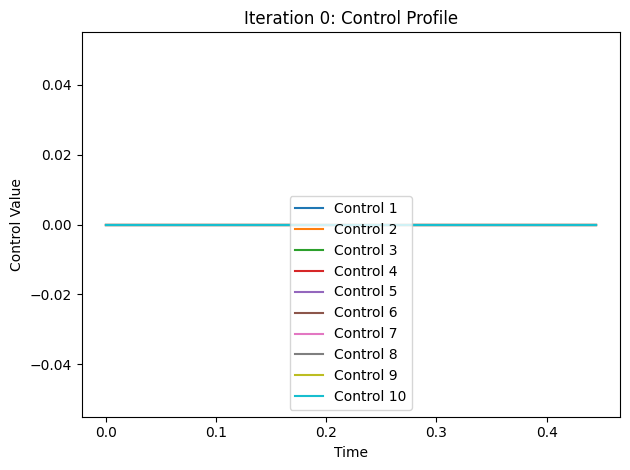

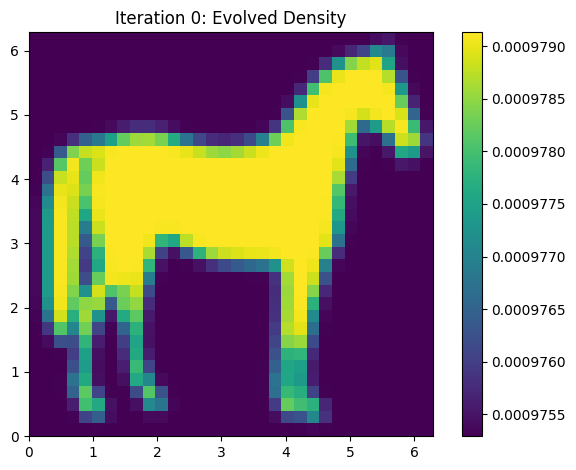

Iteration 1, Cost: 9.3100e-02


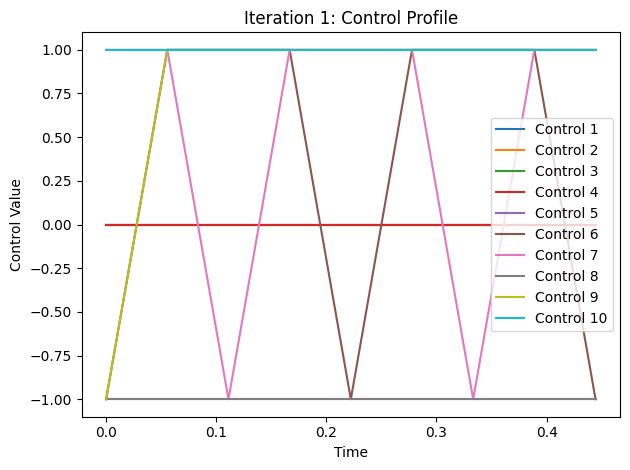

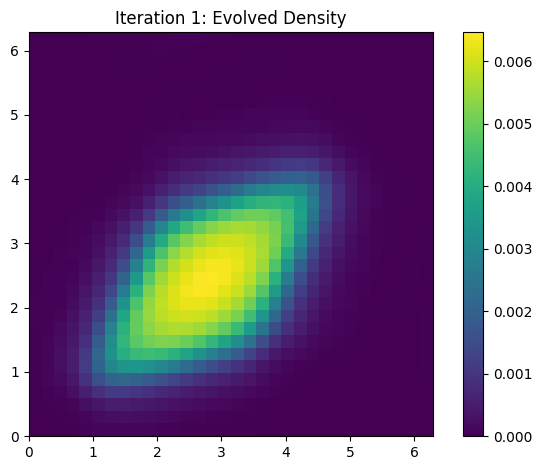

Iteration 2, Cost: 8.7649e-02


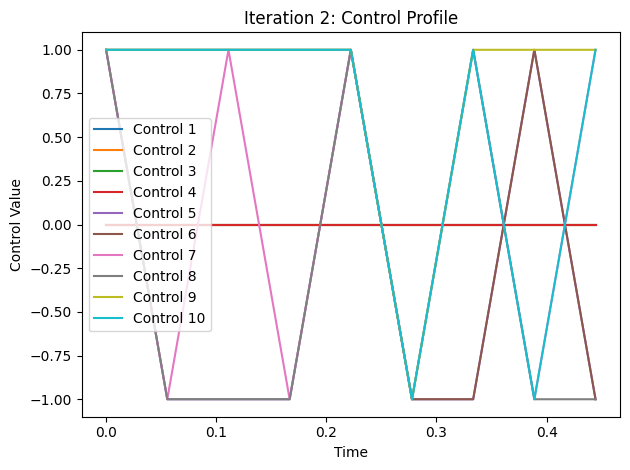

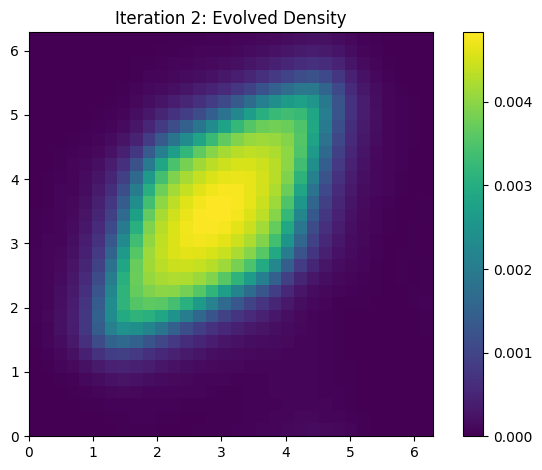

Final Cost: 8.1879e-02


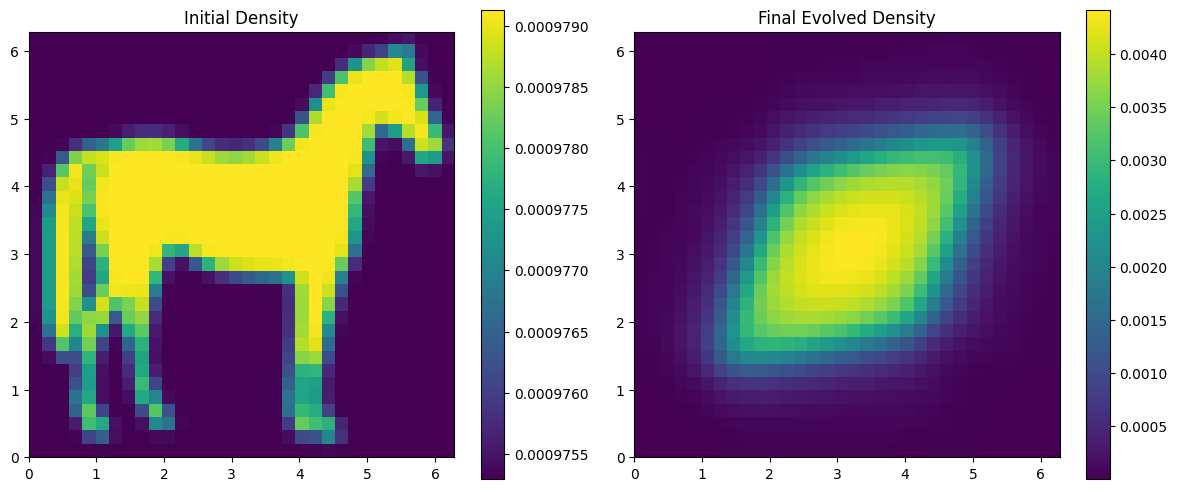

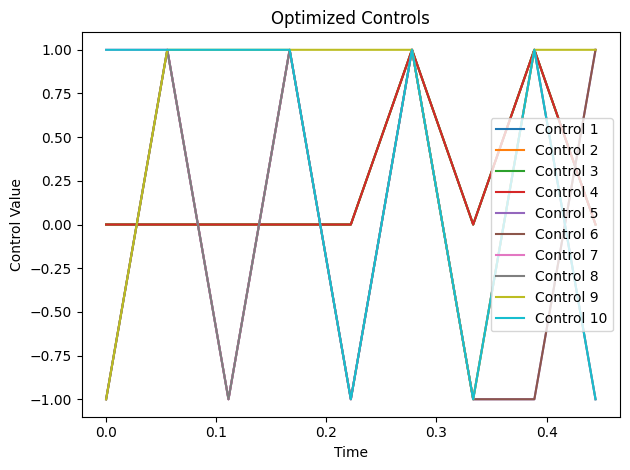

In [ ]:
try:
    import cupy as cp
    xp = cp
    use_gpu = True
    print("Using CuPy on GPU.")
except ImportError:
    import numpy as xp
    use_gpu = False
    print("Using NumPy on CPU.")

import numpy as np  # for plotting conversion
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize

def to_numpy(arr):
    """Converts array to NumPy array if using CuPy."""
    if use_gpu:
        return cp.asnumpy(arr)
    else:
        return arr

def get_user_config():
    config = {}

    # PDE / domain parameters
    config["res"] = 32            # Grid resolution
    config["T"]   = 0.5           # Total time horizon
    config["h"]   = config["T"] / 9
    config["epsilon"] = 0.1 * config["h"]
    config["N_iter"] = 3

    # Query/Key matrices (fixed) for attention (here, Q=K=I)
    config["Q_mat"] = xp.array([[1.0,  0.0],
                                [0.0,  1.0]])
    config["K_mat"] = xp.array([[1.0,  0.0],
                                [0.0,  1.0]])

    # Control dimension: 10 channels (first 4 for local drift are unused)
    config["num_channels"] = 10

    # Initial control array
    n_intervals = int(config["T"] / config["h"])
    config["initial_control"] = xp.zeros((config["num_channels"], n_intervals))

    # Active channels (not strictly used here)
    config["active"] = xp.array([0,0,0,0,1,0,1,0,0,0], dtype=xp.float32)

    # Spectral sub-steps and aliasing filter
    config["num_steps_per_interval"] = 8
    config["use_two_thirds_filter"]  = True

    # Sign-based update factor (not used directly in vectorized code)
    config["sign_factor"] = 300.0

    # Density clipping
    config["rho_clip"] = 1e-15

    # (Unused) local drift parameters are removed.
    config["use_sigmoid_local"] = True

    # Smoothness penalty weight
    config["lam_cost"] = 0.00000

    # Reference point for cost (torus wrapping)
    config["xstar"] = np.pi
    config["ystar"] = np.pi

    # Concentration parameter for periodic attention kernel
    config["kappa"] = 5.0

    return config

def main_simulation(config):
    # Unpack configuration parameters
    res   = config["res"]
    T     = config["T"]
    h     = config["h"]
    eps   = config["epsilon"]
    N_iter= config["N_iter"]
    Q_mat = config["Q_mat"]
    K_mat = config["K_mat"]
    kappa = config["kappa"]

    num_channels = config["num_channels"]
    bar_u        = config["initial_control"].copy()
    num_steps_per_interval = config["num_steps_per_interval"]
    use_two_thirds_filter  = config["use_two_thirds_filter"]
    rho_clip               = config["rho_clip"]

    xstar = config["xstar"]
    ystar = config["ystar"]

    # ---------- Grid Setup ----------
    x = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    y = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    dx = 2*xp.pi / res
    X, Y = xp.meshgrid(x, y, indexing='ij')
    area_el = float(dx * dx)

    # Frequencies for spectral derivatives (using xp.fft)
    k = xp.fft.fftfreq(res) * res
    kx, ky = xp.meshgrid(k, k, indexing='ij')

    # ========== Initial Density ==========
    # Use NumPy for image processing then convert to xp.array.
    image = data.horse().astype(float)
    image_inverted = 255 - image
    image_resized = resize(image_inverted, (res, res), anti_aliasing=True)
    image_resized = np.flipud(image_resized)
    rho_initial = xp.array(image_resized) / xp.sum(image_resized)
    original_rho = rho_initial.copy()

    # Flattened coordinate array for attention computations (on GPU if available)
    coords = xp.stack([X.flatten(), Y.flatten()], axis=1)
    N = coords.shape[0]  # total grid points

    # ========== 2/3 Aliasing Filter ==========
    def two_thirds_filter(f_hat):
        Nx, Ny = f_hat.shape
        cutoff_x = Nx // 3
        cutoff_y = Ny // 3
        f_hat[cutoff_x:-cutoff_x, :] = 0
        f_hat[:, cutoff_y:-cutoff_y] = 0
        return f_hat

    # ========== Local Drift (Removed) ==========
    def compute_local_drift(u):
        # Removed local drift returns zeros.
        return xp.zeros_like(X), xp.zeros_like(X)

    # ========== Periodic Attention Drift ==========
    def compute_periodic_attention_drift(rho, u):
        """
        f_attn(p) = V * [ ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) y rho(y) dy /
                           ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) rho(y) dy ] + b
        (with Q=K=I, so (Qx)_j = x_j and (Ky)_j = y_j)
        """
        # Extract V (channels 4:8) and b (channels 8:10)
        V = xp.array([[u[4], u[5]],
                      [u[6], u[7]]])
        b = xp.array([u[8], u[9]])

        rho_flat = rho.flatten()  # shape (N,)

        # p_proj and q_proj are simply coords here.
        p_proj = coords  # shape (N,2)
        q_proj = coords  # shape (N,2)

        # Inline vectorized periodic difference:
        diff_mat = p_proj[:, None, :] - q_proj[None, :, :]  # shape (N,N,2)
        # Wrap differences into [-pi, pi]
        diff_mat = (diff_mat + xp.pi) % (2*xp.pi) - xp.pi

        # Compute cosine similarity for each coordinate and sum over dimensions:
        cos_sum = xp.cos(diff_mat[..., 0]) + xp.cos(diff_mat[..., 1])  # shape (N, N)
        stable_scores = kappa * cos_sum
        row_max = xp.max(stable_scores, axis=1, keepdims=True)
        stable_scores = stable_scores - row_max  # for stability
        exp_scores = xp.exp(stable_scores)

        weights = exp_scores * rho_flat[None, :]  # shape (N, N)
        denom = xp.sum(weights, axis=1) + 1e-15  # avoid division by zero
        num = weights @ coords  # shape (N, 2)
        attn_vec = num / denom[:, None]
        attn_out = attn_vec @ V.T + b
        return attn_out.reshape((res, res, 2))[:,:,0], attn_out.reshape((res, res, 2))[:,:,1]

    # ========== PDE Derivative ==========
    def compute_rho_derivative(t, rho, u):
        # Local drift is zero
        _, _ = compute_local_drift(u)
        non_x, non_y = compute_periodic_attention_drift(rho, u)
        drift_x = non_x
        drift_y = non_y

        flux_x = rho * drift_x
        flux_y = rho * drift_y

        flux_x_hat = xp.fft.fft2(flux_x)
        flux_y_hat = xp.fft.fft2(flux_y)

        if use_two_thirds_filter:
            flux_x_hat = two_thirds_filter(flux_x_hat)
            flux_y_hat = two_thirds_filter(flux_y_hat)

        div_flux = xp.fft.ifft2(1j * kx * flux_x_hat + 1j * ky * flux_y_hat).real
        return -div_flux

    # ========== Helper: Torus-Wrapped Coordinate Difference ==========
    def torus_diff(A, a_star):
        return (A - a_star + xp.pi) % (2*xp.pi) - xp.pi

    # ========== Cost Functional (α=2) ==========
    def compute_cost(rho):
        dx_wrap = torus_diff(X, xstar)
        dy_wrap = torus_diff(Y, ystar)
        return float(xp.sum((dx_wrap**2 + dy_wrap**2) * rho) * area_el)

    # ========== Time-Stepping ==========
    def simulate_duration(t0, rho_init, control_intervals, total_time, interval_length):
        rho = rho_init.copy()
        t = t0
        dt = interval_length / num_steps_per_interval
        n_full = int(total_time // interval_length)
        remainder = total_time - n_full * interval_length

        for j in range(n_full):
            if j < control_intervals.shape[1]:
                u = control_intervals[:, j]
            else:
                u = control_intervals[:, -1]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k2, u)
                k4 = compute_rho_derivative(t + dt, rho + dt*k3, u)
                rho += dt * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        if remainder > 1e-10:
            dt_partial = remainder / num_steps_per_interval
            idx_use = min(n_full, control_intervals.shape[1]-1)
            u = control_intervals[:, idx_use]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k2, u)
                k4 = compute_rho_derivative(t + dt_partial, rho + dt_partial*k3, u)
                rho += dt_partial * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt_partial
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        return rho, t

    def simulate(t0, rho_init, control_intervals, interval_length):
        total_time = control_intervals.shape[1] * interval_length
        rho_out, _ = simulate_duration(t0, rho_init, control_intervals, total_time, interval_length)
        return rho_out

    # ========== Iterative Control Update (Sign-based) ==========
    n_intervals = int(T / h)
    if bar_u.shape != (num_channels, n_intervals):
        raise ValueError(f"Expected bar_u shape ({num_channels}, {n_intervals}), got {bar_u.shape}")

    cost_history = []
    density_evolution = []
    control_history = []
    rho_current_main = rho_initial.copy()

    for k_iter in range(N_iter):
        # Evolve PDE using current controls
        rho_T = simulate(0, rho_current_main, bar_u, h)
        current_cost = compute_cost(rho_T)
        print(f"Iteration {k_iter}, Cost: {current_cost:.4e}")
        cost_history.append(current_cost)
        density_evolution.append(rho_T)

        # Plot and Save Control Profiles per iteration
        t_vals = np.arange(n_intervals) * h
        plt.figure()
        for ch in range(num_channels):
            plt.plot(np.array(t_vals), np.array(to_numpy(bar_u[ch, :])), label=f'Control {ch+1}')
        plt.xlabel('Time')
        plt.ylabel('Control Value')
        plt.title(f'Iteration {k_iter}: Control Profile')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"control_profile_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Plot and Save Evolved Density per iteration
        plt.figure()
        plt.imshow(to_numpy(rho_T), extent=[0,2*np.pi,0,2*np.pi], origin='lower', cmap='viridis')
        plt.title(f'Iteration {k_iter}: Evolved Density')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(f"evolved_density_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Sign-based Update
        t_current = 0.0
        idx = 0
        rho_iter = rho_current_main.copy()
        u_new = xp.zeros_like(bar_u)
        while t_current < T and idx < n_intervals:
            remaining_time = T - t_current
            if bar_u.shape[1] > idx:
                current_controls = bar_u[:, idx:]
            else:
                current_controls = bar_u[:, -1].reshape(num_channels, 1)
            y_bar = simulate_duration(t_current, rho_iter, current_controls, remaining_time, h)[0]
            base_cost = compute_cost(y_bar)
            u_t = xp.zeros(num_channels)
            for i in range(num_channels):
                perturb = xp.zeros((num_channels, 1))
                perturb[i, 0] = 1.0
                y_pert = simulate_duration(t_current, rho_iter, perturb, eps, eps)[0]
                z_bar = simulate_duration(t_current, y_pert, current_controls, remaining_time, h)[0]
                cost_pert = compute_cost(z_bar)
                u_t[i] = np.sign(base_cost - cost_pert)
            u_new[:, idx] = u_t
            rho_iter = simulate_duration(t_current, rho_iter, u_t.reshape(num_channels, 1), h, h)[0]
            t_current += h
            idx += 1

        bar_u = u_new.copy()
        control_history.append(bar_u.copy())
        # Re-simulate from 0 to T with new controls
        rho_current_main = simulate(0, rho_current_main, bar_u, h)

    # Final Results
    rho_final = simulate(0, rho_current_main, bar_u, h)
    final_cost = compute_cost(rho_final)
    print(f"Final Cost: {final_cost:.4e}")

    # Final Summary Plots: Initial and Final Density (without cost history)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(to_numpy(original_rho), extent=[0,2*xp.pi,0,2*xp.pi], origin='lower', cmap='viridis')
    plt.title('Initial Density')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(to_numpy(rho_final), extent=[0,2*xp.pi,0,2*xp.pi], origin='lower', cmap='viridis')
    plt.title('Final Evolved Density')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig("final_results.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    # Separate Figure: Plot Optimized Controls
    plt.figure()
    t_vals = np.arange(n_intervals) * h
    for ch in range(num_channels):
        plt.plot(np.array(t_vals), np.array(to_numpy(bar_u[ch, :])), label=f'Control {ch+1}')
    plt.xlabel('Time')
    plt.ylabel('Control Value')
    plt.title('Optimized Controls')
    plt.legend()
    plt.tight_layout()
    plt.savefig("optimized_controls.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

if __name__ == "__main__":
    config = get_user_config()
    main_simulation(config)


Using CuPy on GPU.
Iteration 0, Cost: 2.5416e-01


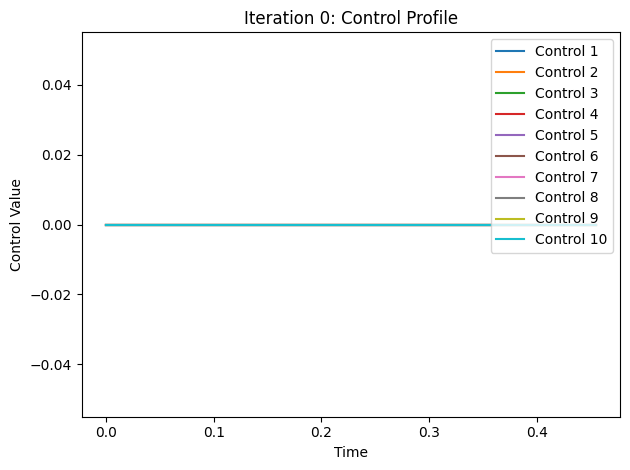

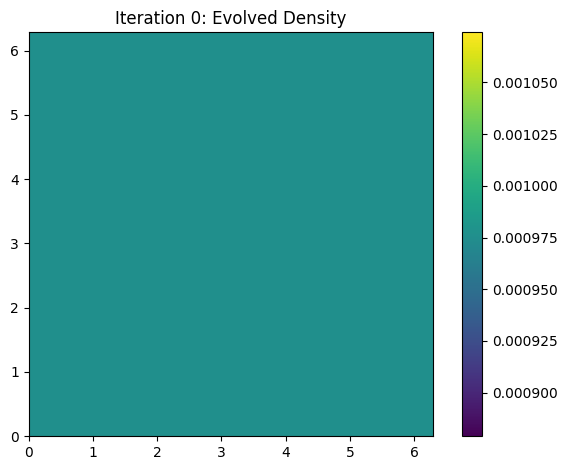

Iteration 1, Cost: 9.5332e-02


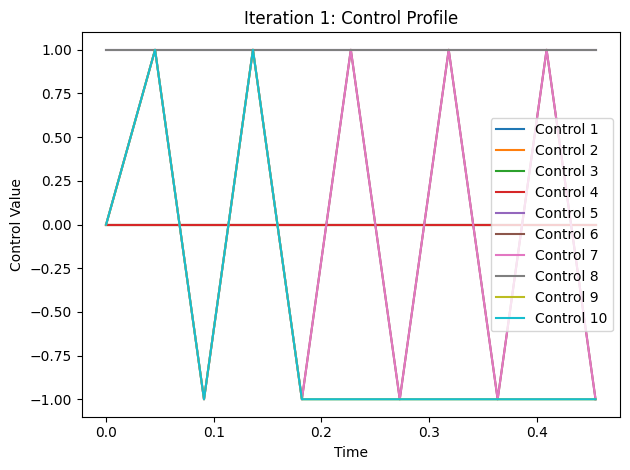

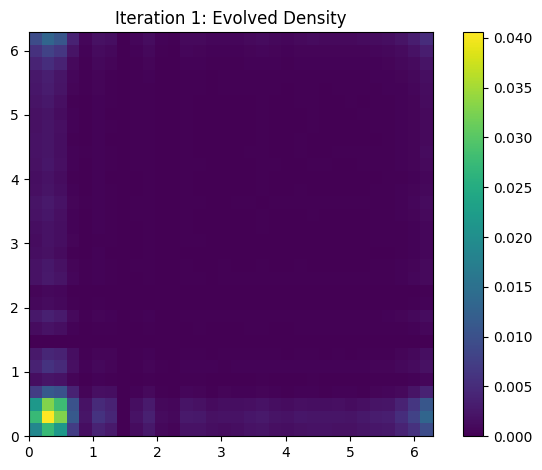

Final Cost: 7.8124e-02


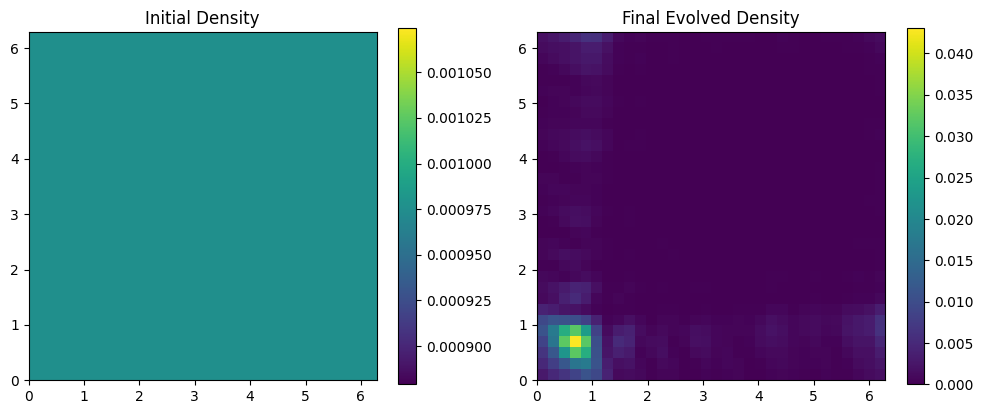

In [ ]:
try:
    import cupy as cp
    xp = cp
    use_gpu = True
    print("Using CuPy on GPU.")
except ImportError:
    import numpy as xp
    use_gpu = False
    print("Using NumPy on CPU.")

import numpy as np  # still needed for plotting conversion
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import resize

def to_numpy(arr):
    """Converts array to NumPy array if using CuPy."""
    if use_gpu:
        return cp.asnumpy(arr)
    else:
        return arr

def get_user_config():
    config = {}

    # PDE / domain parameters
    config["res"] = 32           # Grid resolution
    config["T"]   = 0.5           # Total time horizon
    config["h"]   = config["T"] / 11
    config["epsilon"] = 0.1 * config["h"]
    config["N_iter"] = 2

    # Query/Key matrices (fixed) for attention (here, Q=K=I)
    config["Q_mat"] = xp.array([[1.0,  0.0],
                                [0.0,  1.0]])
    config["K_mat"] = xp.array([[1.0,  0.0],
                                [0.0,  1.0]])

    # Control dimension: 10 channels (first 4 for local drift are unused)
    config["num_channels"] = 10

    # Initial control array
    n_intervals = int(config["T"] / config["h"])
    config["initial_control"] = xp.zeros((config["num_channels"], n_intervals))

    # Active channels (not strictly used here)
    config["active"] = xp.array([0,0,0,0,1,1,1,1,0,0], dtype=xp.float32)

    # Spectral sub-steps and aliasing filter
    config["num_steps_per_interval"] = 8
    config["use_two_thirds_filter"]  = True

    # Sign-based update factor (not used directly in vectorized code)
    config["sign_factor"] = 300.0

    # Density clipping
    config["rho_clip"] = 1e-15

    # (Unused) local drift parameters are removed.
    config["use_sigmoid_local"] = True

    # Smoothness penalty weight
    config["lam_cost"] = 0.00000

    # Reference point for cost (torus wrapping)
    config["xstar"] = 0
    config["ystar"] = 0 #np.pi

    # Concentration parameter for periodic attention kernel
    config["kappa"] = 5.0

    return config

def main_simulation(config):
    # Unpack configuration parameters
    res   = config["res"]
    T     = config["T"]
    h     = config["h"]
    eps   = config["epsilon"]
    N_iter= config["N_iter"]
    Q_mat = config["Q_mat"]
    K_mat = config["K_mat"]
    kappa = config["kappa"]

    num_channels = config["num_channels"]
    bar_u        = config["initial_control"].copy()
    num_steps_per_interval = config["num_steps_per_interval"]
    use_two_thirds_filter  = config["use_two_thirds_filter"]
    rho_clip               = config["rho_clip"]

    xstar = config["xstar"]
    ystar = config["ystar"]

    # ---------- Grid Setup ----------
    x = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    y = xp.linspace(0, 2*xp.pi, res, endpoint=False)
    dx = 2*xp.pi / res
    X, Y = xp.meshgrid(x, y, indexing='ij')
    area_el = float(dx * dx)

    # Frequencies for spectral derivatives (using xp.fft)
    k = xp.fft.fftfreq(res) * res
    kx, ky = xp.meshgrid(k, k, indexing='ij')

    # ========== Initial Density ==========
    # Note: We use NumPy for image loading and resizing.
    image = data.horse().astype(float)
    image_inverted = image*0.0 + 255
    image_resized = resize(image_inverted, (res, res), anti_aliasing=True)
    image_resized = np.flipud(image_resized)
    rho_initial = xp.array(image_resized) / xp.sum(image_resized)
    original_rho = rho_initial.copy()

    # Flattened coordinate array for attention computations (on GPU if available)
    coords = xp.stack([X.flatten(), Y.flatten()], axis=1)
    N = coords.shape[0]  # total grid points

    # ========== 2/3 Aliasing Filter ==========
    def two_thirds_filter(f_hat):
        Nx, Ny = f_hat.shape
        cutoff_x = Nx // 3
        cutoff_y = Ny // 3
        f_hat[cutoff_x:-cutoff_x, :] = 0
        f_hat[:, cutoff_y:-cutoff_y] = 0
        return f_hat

    # ========== Local Drift (Removed) ==========
    def compute_local_drift(u):
        # Removed local drift returns zeros.
        return xp.zeros_like(X), xp.zeros_like(X)

    # ========== Periodic Attention Drift ==========
    def compute_periodic_attention_drift(rho, u):
        """
        f_attn(p) = V * [ ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) y rho(y) dy /
                           ∫ exp( kappa * Σ_j cos((x)_j - (y)_j) ) rho(y) dy ] + b
        (with Q=K=I, so (Qx)_j = x_j and (Ky)_j = y_j)
        """
        # Extract V (channels 4:8) and b (channels 8:10)
        V = xp.array([[u[4], u[5]],
                      [u[6], u[7]]])
        b = xp.array([u[8], u[9]])

        rho_flat = rho.flatten()  # shape (N,)

        # p_proj and q_proj are simply coords here.
        p_proj = coords  # shape (N,2)
        q_proj = coords  # shape (N,2)

        # Inline vectorized periodic difference:
        diff_mat = p_proj[:, None, :] - q_proj[None, :, :]  # shape (N, N, 2)
        # Wrap differences into [-pi, pi]
        diff_mat = (diff_mat + xp.pi) % (2*xp.pi) - xp.pi

        # Compute cosine similarity for each coordinate and sum over dimensions:
        cos_sum = xp.cos(diff_mat[..., 0]) + xp.cos(diff_mat[..., 1])  # shape (N, N)
        stable_scores = kappa * cos_sum
        row_max = xp.max(stable_scores, axis=1, keepdims=True)
        stable_scores = stable_scores - row_max  # for stability
        exp_scores = xp.exp(stable_scores)

        weights = exp_scores * rho_flat[None, :]  # shape (N, N)
        denom = xp.sum(weights, axis=1) + 1e-15  # avoid division by zero
        num = weights @ coords  # shape (N, 2)
        attn_vec = num / denom[:, None]
        attn_out = attn_vec @ V.T + b
        return attn_out.reshape((res, res, 2))[:,:,0], attn_out.reshape((res, res, 2))[:,:,1]

    # ========== PDE Derivative ==========
    def compute_rho_derivative(t, rho, u):
        # Only periodic attention contributes (local drift is zero)
        # (We still call compute_local_drift to keep the interface but ignore its result.)
        _, _ = compute_local_drift(u)
        non_x, non_y = compute_periodic_attention_drift(rho, u)
        drift_x = non_x
        drift_y = non_y

        flux_x = rho * drift_x
        flux_y = rho * drift_y

        flux_x_hat = xp.fft.fft2(flux_x)
        flux_y_hat = xp.fft.fft2(flux_y)

        if use_two_thirds_filter:
            flux_x_hat = two_thirds_filter(flux_x_hat)
            flux_y_hat = two_thirds_filter(flux_y_hat)

        div_flux = xp.fft.ifft2(1j * kx * flux_x_hat + 1j * ky * flux_y_hat).real
        return -div_flux

    # ========== Helper: Torus-Wrapped Coordinate Difference ==========
    def torus_diff(A, a_star):
        return (A - a_star + xp.pi) % (2*xp.pi) - xp.pi

    # ========== Cost Functional (α=2) ==========
    def compute_cost(rho):
        dx_wrap = torus_diff(X, xstar)
        dy_wrap = torus_diff(Y, ystar)
        return float(xp.sum((dx_wrap**2 + dy_wrap**2) * rho) * area_el)

    # ========== Time-Stepping ==========
    def simulate_duration(t0, rho_init, control_intervals, total_time, interval_length):
        rho = rho_init.copy()
        t = t0
        dt = interval_length / num_steps_per_interval
        n_full = int(total_time // interval_length)
        remainder = total_time - n_full * interval_length

        for j in range(n_full):
            if j < control_intervals.shape[1]:
                u = control_intervals[:, j]
            else:
                u = control_intervals[:, -1]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt, rho + 0.5*dt*k2, u)
                k4 = compute_rho_derivative(t + dt, rho + dt*k3, u)
                rho += dt * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        if remainder > 1e-10:
            dt_partial = remainder / num_steps_per_interval
            idx_use = min(n_full, control_intervals.shape[1]-1)
            u = control_intervals[:, idx_use]
            for _ in range(num_steps_per_interval):
                k1 = compute_rho_derivative(t, rho, u)
                k2 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k1, u)
                k3 = compute_rho_derivative(t + 0.5*dt_partial, rho + 0.5*dt_partial*k2, u)
                k4 = compute_rho_derivative(t + dt_partial, rho + dt_partial*k3, u)
                rho += dt_partial * (k1 + 2*k2 + 2*k3 + k4) / 6
                t += dt_partial
                rho = xp.maximum(rho, rho_clip)
                rho /= xp.sum(rho)
        return rho, t

    def simulate(t0, rho_init, control_intervals, interval_length):
        total_time = control_intervals.shape[1] * interval_length
        rho_out, _ = simulate_duration(t0, rho_init, control_intervals, total_time, interval_length)
        return rho_out

    # ========== Iterative Control Update (Sign-based) ==========
    n_intervals = int(T / h)
    if bar_u.shape != (num_channels, n_intervals):
        raise ValueError(f"Expected bar_u shape ({num_channels}, {n_intervals}), got {bar_u.shape}")

    cost_history = []
    density_evolution = []
    control_history = []
    rho_current_main = rho_initial.copy()

    for k_iter in range(N_iter):
        # Evolve PDE using current controls
        rho_T = simulate(0, rho_current_main, bar_u, h)
        current_cost = compute_cost(rho_T)
        print(f"Iteration {k_iter}, Cost: {current_cost:.4e}")
        cost_history.append(current_cost)
        density_evolution.append(rho_T)

        # Plot and Save Control Profiles
        t_vals = np.arange(n_intervals) * h
        plt.figure()
        for ch in range(num_channels):
            plt.plot(np.array(t_vals), np.array(to_numpy(bar_u[ch, :])), label=f'Control {ch+1}')
        plt.xlabel('Time')
        plt.ylabel('Control Value')
        plt.title(f'Iteration {k_iter}: Control Profile')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"control_profile_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Plot and Save Evolved Density
        plt.figure()
        plt.imshow(to_numpy(rho_T), extent=[0,2*np.pi,0,2*np.pi], origin='lower', cmap='viridis')
        plt.title(f'Iteration {k_iter}: Evolved Density')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(f"evolved_density_iter{k_iter}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # Sign-based Update
        t_current = 0.0
        idx = 0
        rho_iter = rho_current_main.copy()
        u_new = xp.zeros_like(bar_u)
        while t_current < T and idx < n_intervals:
            remaining_time = T - t_current
            if bar_u.shape[1] > idx:
                current_controls = bar_u[:, idx:]
            else:
                current_controls = bar_u[:, -1].reshape(num_channels, 1)
            y_bar = simulate_duration(t_current, rho_iter, current_controls, remaining_time, h)[0]
            base_cost = compute_cost(y_bar)
            u_t = xp.zeros(num_channels)
            for i in range(num_channels):
                perturb = xp.zeros((num_channels, 1))
                perturb[i, 0] = 1.0
                y_pert = simulate_duration(t_current, rho_iter, perturb, eps, eps)[0]
                z_bar = simulate_duration(t_current, y_pert, current_controls, remaining_time, h)[0]
                cost_pert = compute_cost(z_bar)
                u_t[i] = np.sign(base_cost - cost_pert)
            u_new[:, idx] = u_t
            rho_iter = simulate_duration(t_current, rho_iter, u_t.reshape(num_channels, 1), h, h)[0]
            t_current += h
            idx += 1

        bar_u = u_new.copy()
        control_history.append(bar_u.copy())
        # Re-simulate from 0 to T with new controls
        rho_current_main = simulate(0, rho_current_main, bar_u, h)

    # Final Results
    rho_final = simulate(0, rho_current_main, bar_u, h)
    final_cost = compute_cost(rho_final)
    print(f"Final Cost: {final_cost:.4e}")

    # Final Summary Plots: Display and Save
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(to_numpy(original_rho), extent=[0,2*np.pi,0,2*np.pi], origin='lower', cmap='viridis')
    plt.title('Initial Density')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(to_numpy(rho_final), extent=[0,2*np.pi,0,2*np.pi], origin='lower', cmap='viridis')
    plt.title('Final Evolved Density')
    plt.colorbar()
    # plt.subplot(1, 3, 3)
    # plt.plot(range(N_iter), cost_history, marker='o')
    # plt.xlabel('Iteration')
    # plt.ylabel('Cost')
    # plt.title('Cost History')
    plt.tight_layout()
    plt.savefig("final_results.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

if __name__ == "__main__":
    config = get_user_config()
    main_simulation(config)
